In [97]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import stan

## These are needed when running in a notebook
import nest_asyncio
nest_asyncio.apply()

In [2]:
# Load data set
country = pd.read_parquet("data/country.parquet").set_index("country_id")
target = pd.read_parquet("data/target.parquet").set_index(["trial_id", "site_id"])
site = pd.read_parquet("data/trial_site.parquet")
trial = pd.read_parquet("data/trial.parquet").set_index("trial_id")
df = site.join(trial, on="trial_id").join(target, on=["trial_id", "site_id"]).join(country, on="country_id")


In [3]:
# Define target variable
df["enrolment_speed"] = df["no_of_patients"] / df["enrolment_months"]
df.loc[df["enrolment_speed"] <= 0, "enrolment_speed"] = np.NaN

We will be assuming a normal distribution for the target variable. This is a massive oversimplification, as we should at least account for zero-inflated outcomes. Zero-inflated Poisson might be a better choice here.

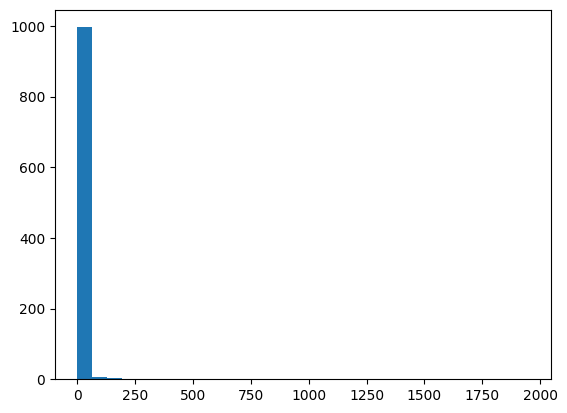

In [14]:
plt.hist(df["enrolment_speed"], bins=30)
plt.show()

In [7]:
# Do something about the extreme values
target_stats = df["enrolment_speed"].describe()
iqr = target_stats["75%"] - target_stats["25%"]
three_sigma_upper = target_stats["75%"] + 1.5 * iqr
three_sigma_lower = max(target_stats["25%"] - 1.5 * iqr, 0)

In [8]:
# Tag sites that need to be imputed
df["impute"] = np.logical_or(np.logical_or(df["enrolment_speed"] < three_sigma_lower, df["enrolment_speed"] > three_sigma_upper), df["enrolment_speed"].isna())

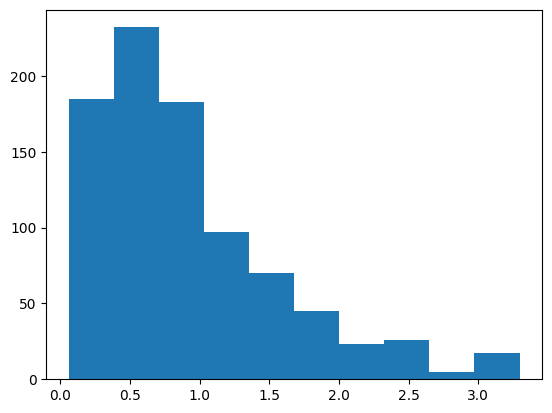

In [13]:
plt.hist(df["enrolment_speed"][np.logical_not(df["impute"])])
plt.show()

Yea, that normal distribution is a long shot... however, we'll roll with it


Next up, we need some features. I have arbitrarily chosen minimum age for the study and health expenditure per capita.

In [15]:
# Feature engineering
features = df[["site_id", "trial_id", "enrolment_speed", "impute", "minimum_age", "who_gho_ghed_che_pc_ppp_sha2011_curr_health_exp_per_capita_ppp"]].rename(columns={
    "who_gho_ghed_che_pc_ppp_sha2011_curr_health_exp_per_capita_ppp": "gdp_pc"
})
features = features[np.logical_not(features["gdp_pc"].isna())]

We extract our features and do a quick and dirty normalisation

In [16]:
# Sites with complete data
complete = features[np.logical_not(features["impute"])].copy()
complete["minimum_age"] = complete["minimum_age"] - min(complete["minimum_age"])
max_observed_speed = max(complete["enrolment_speed"])
complete["enrolment_speed"] = complete["enrolment_speed"] / max_observed_speed
max_gdp_pc = max(complete["gdp_pc"])
complete["gdp_pc"] = complete["gdp_pc"] / max_gdp_pc

# Sites to be imputed
incomplete = features[features["impute"]].copy()
incomplete["minimum_age"] = incomplete["minimum_age"] - min(incomplete["minimum_age"])
incomplete["gdp_pc"] = incomplete["gdp_pc"] / max_gdp_pc

Model time!

In [17]:
# Define a model and its data
data = {
    "N": len(complete),
    "N_inc": len(incomplete),
    "D": 2,
    "y": complete["enrolment_speed"].to_list(),
    "X": complete[["minimum_age", "gdp_pc"]].to_numpy(),
    "X_inc": incomplete[["minimum_age", "gdp_pc"]].to_numpy()
}

stan_code = """
// Bayesian Linear Regression
data {
    int<lower = 0> N;
    int<lower = 0> N_inc;
    vector[N] y; 
    int<lower=0> D;
    matrix[N, D] X;  
    matrix[N_inc, D] X_inc;
}
parameters {
    vector[D] beta;
    real<lower=0> sigma;
}
model {
    sigma ~ exponential(1);
    beta ~ normal(0, 1);
    y ~ normal(X * beta, sigma);
}
generated quantities {
    vector[N_inc] y_imputed;
    vector[N] log_lik;
    for (n in 1:N_inc) {
        y_imputed[n] = X_inc[n, ] * beta;
    }
    for (n in 1:N) {
        log_lik[n] = normal_lpdf(y[n] | X[n, ] * beta, sigma);
    }
}
"""

In [18]:
# Fit our model and impute in one step
posterior = stan.build(
    program_code=stan_code,
    data = data,
    random_seed=4444
)

fit = posterior.sample(num_samples=1000, num_chains=4)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   8% (600/8000)
Sampling:  15% (1200/8000)
Sampling:  20% (1600/8000)
Sampling:  42% (3400/8000)
Sampling:  62% (5000/8000)
Sampling:  80% (6400/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 7.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_cjhzb6m9/model_jdvycpsw.stan', line 18, column 4 to column 32)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecif

Complaints about a misspecified model were to be expected

Let's validate the model. We will approximate LOO-CV by estimating the Expected Log Pointwise Density (ELPD).

In [19]:
# Approximate Leave One Out Cross Validation
idata = az.from_pystan(posterior=fit, posterior_model=posterior, log_likelihood="log_lik")
az.loo(idata)

Computed from 4000 posterior samples and 879 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    44.38    28.42
p_loo        3.97        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      879  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

As a baseline, I imagine the case where the target variable is predicted entirely by sampling from the marginal data distributon. We can then calculate ELPD:

In [106]:
reps = 100000
y = complete["enrolment_speed"].to_numpy()
y_sample = np.random.choice(y, size=reps, replace=True)
likelihood = gaussian_kde(y_sample)(y)
np.sum(np.log(likelihood))

396.89196769662993

Not surprisingly, the model is doing worse than a random baseline

The model would otherwise have given us easily interpretable parameters

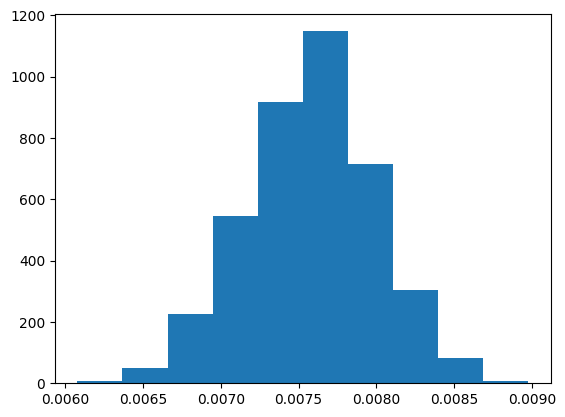

In [111]:
plt.hist(fit["beta"][0,:]) # Minimum age coefficient
plt.show()

Higher minimum age means faster recruitment?! Probably not


We also would get a distribution for imputed target values

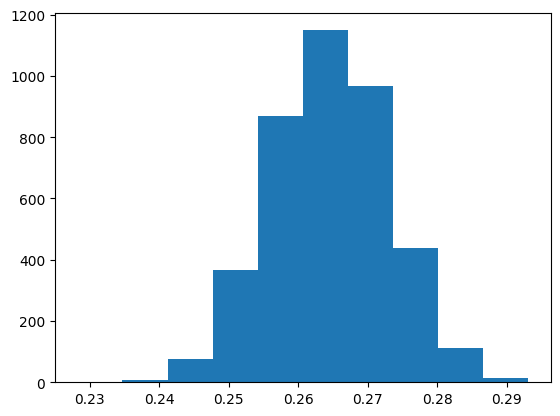

In [112]:
plt.hist(fit["y_imputed"][0,:])
plt.show()